# Analyze model

# 1. Imports

## 1.1 Packages

In [255]:
import os
import numpy as np
import pandas as pd
import pickle
import sys

import shap
import plotly.express as px

In [256]:
# Load custom functions
sys.path.append("../src/")
from prepare_data import get_holidays
from feature_engineering import extract_date_features, add_lockdown_periods, add_holidays_period,\
    get_split_train_val_cv
from train_model import create_pool, unsold_rate, sold_out_rate, compute_shap
from analyze_model import get_soldout_rows

## 1.2 Options

In [257]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [258]:
# Define some parameters

path_data = "../data/processed"
path_model = "../models/model_final.json"

feat_date = "Date"

## 1.3 Datasets

In [259]:
# Load the train and test sets and their targets

df_train = pd.read_pickle(os.path.join(path_data, "train.pkl"))
y_train = pd.read_csv(os.path.join(path_data, "target_train.csv"), index_col=0)

df_test = pd.read_pickle(os.path.join(path_data, "test.pkl"))
y_test = pd.read_csv(os.path.join(path_data, "target_test.csv"), index_col=0)

# 2. Prepare data

## 2.1 Feature engineering

To prepare data, the following feature engineering is done:
1. Extract info from date: year, month, day, day of the week and if its weekend or not
2. Add an indicator of the lockdown period: if there was a lockdown, and which one (first, second or thrid one)
3. Add holidays period for Zone A in France
4. Add holidays period for Zone B in France
5. Add holidays period for Zone C in France

(Having some geographical information could let us add just the right holidays period depending on the zone)

6. Drop columns Date and Fourni which will not be used in the model

In [260]:
df_date_train = df_train[feat_date]
df_date_test = df_test[feat_date]

In [261]:
df_train = df_train.pipe(extract_date_features, feat_date=feat_date)\
    .pipe(add_lockdown_periods, feat_date=feat_date)\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone A")\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone B")\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone C")\
    .drop(columns=["Date", "Fourni"])

df_test = df_test.pipe(extract_date_features, feat_date=feat_date)\
    .pipe(add_lockdown_periods, feat_date=feat_date)\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone A")\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone B")\
    .pipe(add_holidays_period, feat_date=feat_date, zone="Zone C")\
    .drop(columns=["Date", "Fourni"])

In [262]:
df_train

,id,Date_year,Date_month,Date_day,Date_weekday,Date_weekend,lockdown,Description_ZoneA,Description_ZoneB,Description_ZoneC
91,-6795017860123346820,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
71,4324517785573311838,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
70,5056562842583071429,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
68,-5277685202972058648,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
67,4079792561055568638,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël
...,...,...,...,...,...,...,...,...,...,...
64186,6858783929733742556,2022,6,20,0,0,0,None,None,None
64187,2132453013379446212,2022,6,20,0,0,0,None,None,None
64189,8884923748487096025,2022,6,20,0,0,0,None,None,None
64221,2942031581314612067,2022,6,20,0,0,0,None,None,None


In [263]:
df_test

,id,Date_year,Date_month,Date_day,Date_weekday,Date_weekend,lockdown,Description_ZoneA,Description_ZoneB,Description_ZoneC
64222,-8929187383922749181,2022,6,21,1,0,0,None,None,None
64272,-5101409780419083249,2022,6,21,1,0,0,None,None,None
64270,-2438515377832382405,2022,6,21,1,0,0,None,None,None
64269,-2533887189775194793,2022,6,21,1,0,0,None,None,None
64268,-677078880490763132,2022,6,21,1,0,0,None,None,None
...,...,...,...,...,...,...,...,...,...,...
83316,294028829836586752,2023,4,17,0,0,0,Vacances de Printemps,Vacances de Printemps,None
83319,-5901808360611692135,2023,4,17,0,0,0,Vacances de Printemps,Vacances de Printemps,None
83318,2132453013379446212,2023,4,17,0,0,0,Vacances de Printemps,Vacances de Printemps,None
83304,-4877794949675591399,2023,4,17,0,0,0,Vacances de Printemps,Vacances de Printemps,None


# 3. Analyze model

In [264]:
# Load model
with open(path_model, "rb") as fp:
    data_model = pickle.load(fp)

model = data_model["model"]
feat = data_model["features"]
feat_cat = data_model["features_cat"]

## 3.1 SHAP values

Check the SHAP values to see the importance of the features

/Users/benjaminwallyn/opt/anaconda3/envs/py310/lib/python3.10/site-packages/shap/plots/_beeswarm.py:340: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



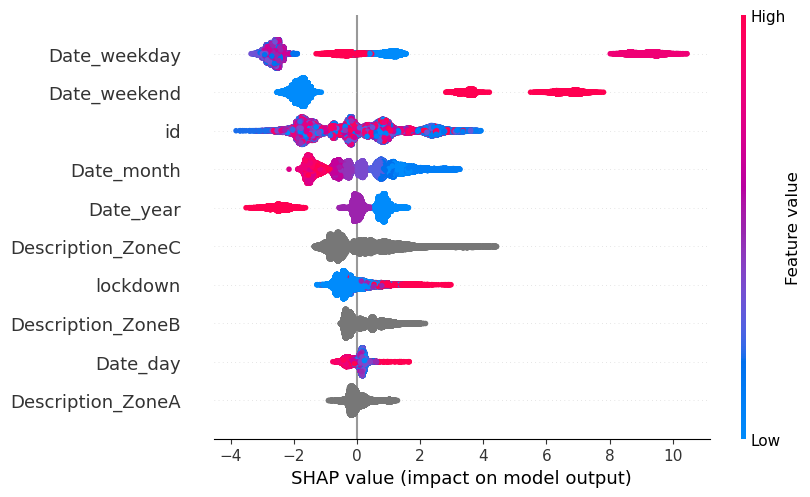

In [265]:
shap_values = compute_shap(model, df_train)
shap.initjs()
shap.plots.beeswarm(shap_values, max_display=10, show=True)

The features about the days of the week are the most important:
* Weekday with the high values, corresponding to the end of the week predicting a higher value
* Weekend with a higher prediction during the weekend
* Id is important as the number of newspapers sold depends on the point of sale
* Month has an influence as the beginning of the year means more sales
* Year. The trend of newspapers' sales is understood by the model

## 3.2 Analyze metrics

In [266]:
pool_train = create_pool(df_train[feat], y_train, feat_cat)
pool_test = create_pool(df_test[feat], y_test, feat_cat)

pred_train = np.round(model.predict(pool_train), 0)
pred_test = np.round(model.predict(pool_test), 0)

/Users/benjaminwallyn/opt/anaconda3/envs/py310/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/Users/benjaminwallyn/opt/anaconda3/envs/py310/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [267]:
df_train[feat_date] = df_date_train
df_test[feat_date] = df_date_test

In [268]:
soldout_train = sold_out_rate(pred_train, y_train.values)
soldout_test = sold_out_rate(pred_test, y_test.values)
unsold_train = unsold_rate(pred_train, y_train.values)
unsold_test = unsold_rate(pred_test, y_test.values)

print("The sold out rates are:", soldout_train, "for the train set and", soldout_test, "for the test set")
print("The unsold rates are:", unsold_train, "for the train set and", unsold_test, "for the test set")

The sold out rates are: 350.6286786459469 for the train set and 95.93522923310158 for the test set
The unsold rates are: 0.6740979483281934 for the train set and 0.6776430275257309 for the test set


### 3.2.1 Sold out

In [269]:
# Get the sold out info
df_train_soldout = get_soldout_rows(df_train, pred_train, y_train.values)
df_train_soldout["missing_papers"] = df_train_soldout['ventes'] - df_train_soldout['fourni']
df_train_soldout

/var/folders/q1/n9jt1sqj3976rqf2zn88_qpc0000gn/T/ipykernel_45191/188345951.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,Date_year,Date_month,Date_day,Date_weekday,Date_weekend,lockdown,Description_ZoneA,Description_ZoneB,Description_ZoneC,Date,ventes,fourni,missing_papers
90,-8793000144743990337,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël,2020-01-02,45.0,30.0,15.0
21,-1139387161625682197,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël,2020-01-02,31.0,29.0,2.0
20,-8817594176277759455,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël,2020-01-02,87.0,31.0,56.0
4,3502243892823802503,2020,1,2,3,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël,2020-01-02,30.0,29.0,1.0
176,6683966329881773101,2020,1,3,4,0,0,Vacances de Noël,Vacances de Noël,Vacances de Noël,2020-01-03,39.0,30.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64212,-8902190327717477004,2022,6,20,0,0,0,None,None,None,2022-06-20,48.0,29.0,19.0
64169,-5497288280538946297,2022,6,20,0,0,0,None,None,None,2022-06-20,70.0,29.0,41.0
64170,-3727119720899292734,2022,6,20,0,0,0,None,None,None,2022-06-20,30.0,29.0,1.0
64167,-4803061667309467787,2022,6,20,0,0,0,None,None,None,2022-06-20,50.0,28.0,22.0


In [270]:
px.box(df_train_soldout, x=f"{feat_date}_weekday", y="missing_papers" , color=f"{feat_date}_weekday", title="Spread of missing papers per day of the week")

The number of sold outs is greater on saturdays.

In [271]:
px.box(df_train_soldout, x=f"{feat_date}_month", y="missing_papers" , color=f"{feat_date}_month", title="Spread of missing papers per month")

In [272]:
px.box(df_train_soldout, x=f"{feat_date}_month", y="missing_papers" , color=f"{feat_date}_weekday", title="Spread of missing papers per day of the week and month")

In [273]:
px.box(df_train_soldout, x=f"{feat_date}_year", y="missing_papers" , color=f"{feat_date}_month", title="Spread of missing papers per month and year")

The number of sold outs during is important during February 2020. It can be explained by the fact that the number of sales is important in february 2020 due to covid.

One improvement could be to have the info of important events that can be predicted, like the elections, sports events or a period with an important event spreading on several days.